In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
import joblib as jb

# Plotting setup
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
# Load preprocessed dataset
df = pd.read_csv('./Preprocessed/preprocessed_air_quality_data.csv')
df.head()

,timestamp,HUMIDITY,LIGHT,NO_MAX,NO_MIN,NO2_MAX,NO2_MIN,OZONE_MAX,OZONE_MIN,PM10_MAX,...,CO_MAX,CO_MIN,CO2_MAX,CO2_MIN,SOUND,TEMPRATURE_MAX,TEMPRATURE_MIN,UV_MAX,UV_MIN,AIR_PRESSURE
0,2019-01-05 00:01:00,0.334970,0.000776,0.0,0.0,0.180380,0.155556,0.017910,0.0,0.592593,...,0.712329,0.304688,0.352765,0.438520,3.134237e-06,0.739130,0.291667,0.0,0.0,0.283276
1,2019-01-05 00:01:00,0.421341,0.000010,0.0,0.0,0.401899,0.342857,0.011940,0.0,0.592593,...,0.910959,0.648438,0.376682,0.488575,7.350537e-06,0.434783,0.291667,0.0,0.0,0.283276
2,2019-01-05 00:01:00,0.358354,0.000007,0.0,0.0,0.316456,0.206349,0.038806,0.0,0.740741,...,0.760274,0.359375,0.295217,0.400435,3.979568e-06,0.260870,0.291667,0.0,0.0,0.283276
3,2019-01-05 00:01:00,0.361050,0.000022,0.0,0.0,0.275316,0.257143,0.011940,0.0,0.611111,...,0.609589,0.296875,0.245889,0.349293,1.903722e-07,0.695652,0.291667,0.0,0.0,0.286689
4,2019-01-05 00:01:00,0.521269,0.000022,0.0,0.0,0.253165,0.190476,0.032836,0.0,0.592593,...,0.280822,0.218750,0.014948,0.001088,1.201762e-05,0.608696,0.208333,0.0,0.0,0.279863


In [6]:
# 80-20 train-test split
train_df = df.iloc[:int(0.8 * len(df))]
test_df = df.iloc[int(0.8 * len(df)):]

# Set target and drop unnecessary columns
target_column = 'PM10_MAX'
drop_cols = [col for col in [target_column, 'NAME', 'LASTUPDATEDATETIME', 'timestamp'] if col in df.columns]

X_train_full = train_df.drop(columns=drop_cols)
y_train_full = train_df[target_column]
X_test = test_df.drop(columns=drop_cols)
y_test = test_df[target_column]

# Train-validation split from training set
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [5]:
xgb_model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [7]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None, ...)

In [8]:
y_pred_train = xgb_model.predict(X_train)
y_pred_val = xgb_model.predict(X_val)


In [10]:
# Evaluate the model on the training and validation sets
train_mae = mean_absolute_error(y_train, y_pred_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_pred_train)
validation_mae = mean_absolute_error(y_val, y_pred_val)
validation_mse = mean_squared_error(y_val, y_pred_val)
validation_rmse = np.sqrt(validation_mse)
validation_r2 = r2_score(y_val, y_pred_val)
print(f"Train MAE: {train_mae}, Train RMSE: {train_rmse}, Train R2: {train_r2*100.:2f}")
print(f"Validation MAE: {validation_mae}, Validation RMSE: {validation_rmse}, Validation R2: {validation_r2*100.:2f}")

Train MAE: 0.0016483765745904642, Train RMSE: 0.002443255499092139, Train R2: 99.988960
Validation MAE: 0.002483487318606452, Validation RMSE: 0.00573546386179659, Validation R2: 99.939287


In [12]:
jb.dump(xgb_model, 'models/xgb_regressor.pkl')

['models/xgb_regressor.pkl']

In [7]:
# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# XGBoost hyperparameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,
    'reg_lambda': 1.0,
    'seed': 42
}

# Define evaluation set
evals = [(dtrain, 'train'), (dval, 'eval')]


# Prepare dictionary to store evaluation results
evals_result = {}

# Train model with evaluation set and early stopping
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=20,
    evals_result=evals_result,   # <-- REQUIRED to access eval history
    verbose_eval=True
)


[0]	train-rmse:0.22212	eval-rmse:0.22236
[1]	train-rmse:0.21153	eval-rmse:0.21177
[2]	train-rmse:0.20166	eval-rmse:0.20191
[3]	train-rmse:0.19212	eval-rmse:0.19239
[4]	train-rmse:0.18308	eval-rmse:0.18334
[5]	train-rmse:0.17464	eval-rmse:0.17494
[6]	train-rmse:0.16650	eval-rmse:0.16681
[7]	train-rmse:0.15878	eval-rmse:0.15909
[8]	train-rmse:0.15159	eval-rmse:0.15192
[9]	train-rmse:0.14538	eval-rmse:0.14573
[10]	train-rmse:0.13878	eval-rmse:0.13914
[11]	train-rmse:0.13292	eval-rmse:0.13331
[12]	train-rmse:0.12698	eval-rmse:0.12738
[13]	train-rmse:0.12135	eval-rmse:0.12178
[14]	train-rmse:0.11599	eval-rmse:0.11640
[15]	train-rmse:0.11090	eval-rmse:0.11134
[16]	train-rmse:0.10640	eval-rmse:0.10684
[17]	train-rmse:0.10184	eval-rmse:0.10230
[18]	train-rmse:0.09756	eval-rmse:0.09803
[19]	train-rmse:0.09342	eval-rmse:0.09389
[20]	train-rmse:0.08954	eval-rmse:0.09001
[21]	train-rmse:0.08594	eval-rmse:0.08642
[22]	train-rmse:0.08247	eval-rmse:0.08297
[23]	train-rmse:0.07908	eval-rmse:0.07956
[2

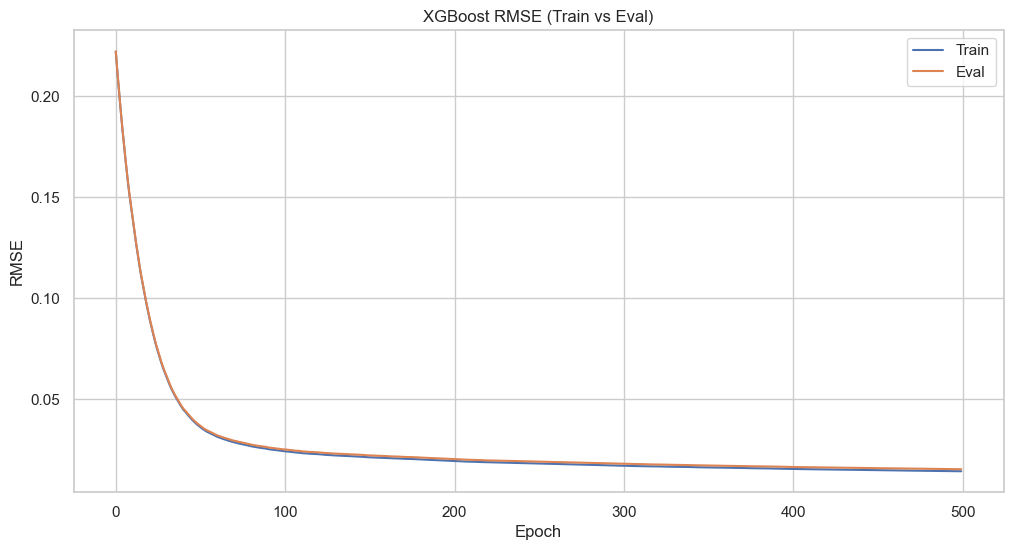

In [8]:
# Extract training history
results = evals_result
epochs = len(results['train']['rmse'])
x_axis = range(epochs)

# Plot RMSE curves
plt.plot(x_axis, results['train']['rmse'], label='Train')
plt.plot(x_axis, results['eval']['rmse'], label='Eval')
plt.title('XGBoost RMSE (Train vs Eval)')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

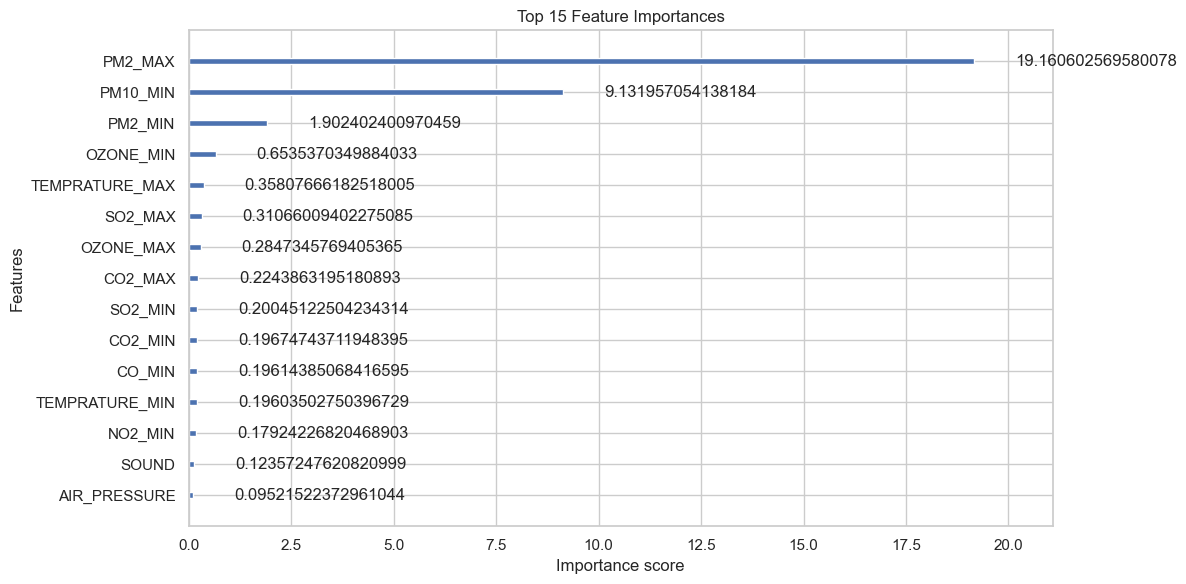

In [9]:
# Top 15 features by gain
xgb.plot_importance(xgb_model, max_num_features=15, importance_type='gain', title='Top 15 Feature Importances')
plt.tight_layout()
plt.show()

In [10]:
# Predict on test data
y_pred = xgb_model.predict(dtest)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 MAE: {mae:.2f}")
print(f"📊 RMSE: {rmse:.2f}")
print(f"📊 R²: {r2:.4f}")

📊 MAE: 0.02
📊 RMSE: 0.03
📊 R²: 0.9828


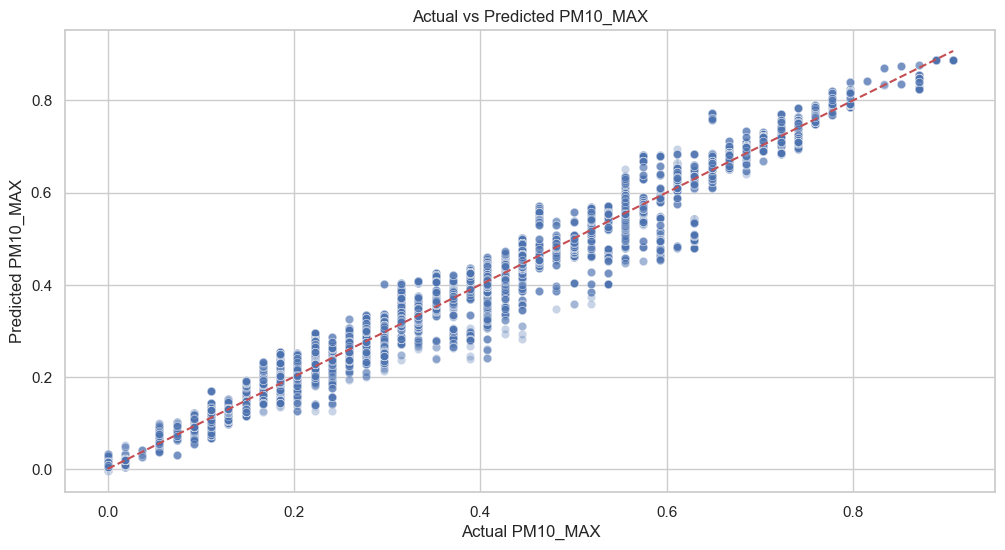

In [11]:
plt.figure()
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted PM10_MAX')
plt.xlabel('Actual PM10_MAX')
plt.ylabel('Predicted PM10_MAX')
plt.grid(True)
plt.show()

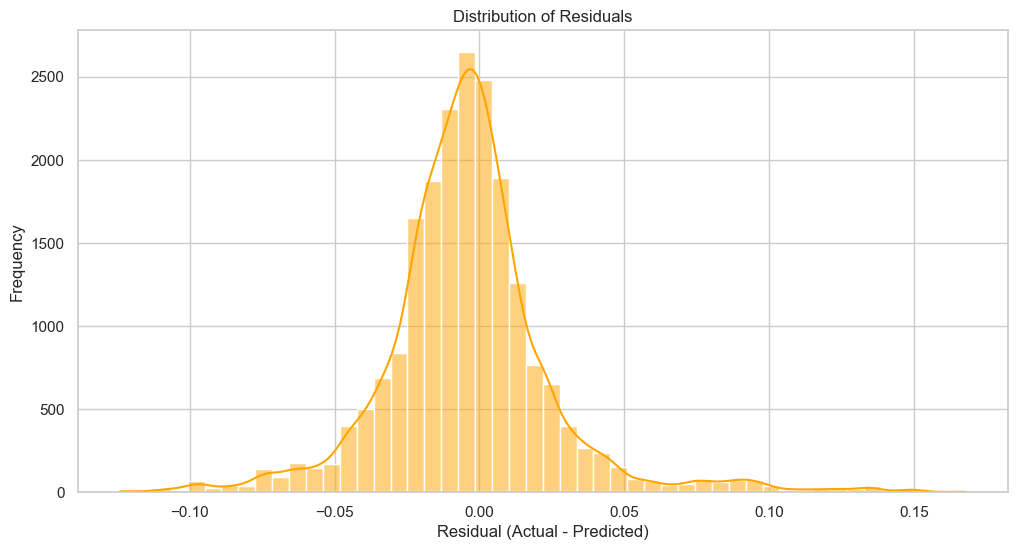

In [12]:
residuals = y_test - y_pred
plt.figure()
sns.histplot(residuals, bins=50, kde=True, color='orange')
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [18]:
jb.dump(xgb_model, 'models/xgb_model.pkl')

['models/xgb_model.pkl']